In [ ]:
!pip install tensorflow

Epoch 1/100
534/534 [==============================] - 12s 15ms/step - loss: 0.0167
Epoch 2/100
534/534 [==============================] - 11s 21ms/step - loss: 0.0122
Epoch 3/100
534/534 [==============================] - 9s 16ms/step - loss: 0.0116
Epoch 4/100
534/534 [==============================] - 11s 21ms/step - loss: 0.0113
Epoch 5/100
534/534 [==============================] - 5s 9ms/step - loss: 0.0112
Epoch 6/100
534/534 [==============================] - 5s 9ms/step - loss: 0.0112
Epoch 7/100
534/534 [==============================] - 7s 13ms/step - loss: 0.0110
Epoch 8/100
534/534 [==============================] - 5s 9ms/step - loss: 0.0110
Epoch 9/100
534/534 [==============================] - 5s 9ms/step - loss: 0.0109
Epoch 10/100
534/534 [==============================] - 7s 13ms/step - loss: 0.0108
Epoch 11/100
534/534 [==============================] - 5s 10ms/step - loss: 0.0108
Epoch 12/100
534/534 [==============================] - 5s 9ms/step - loss: 0.0107
Epo

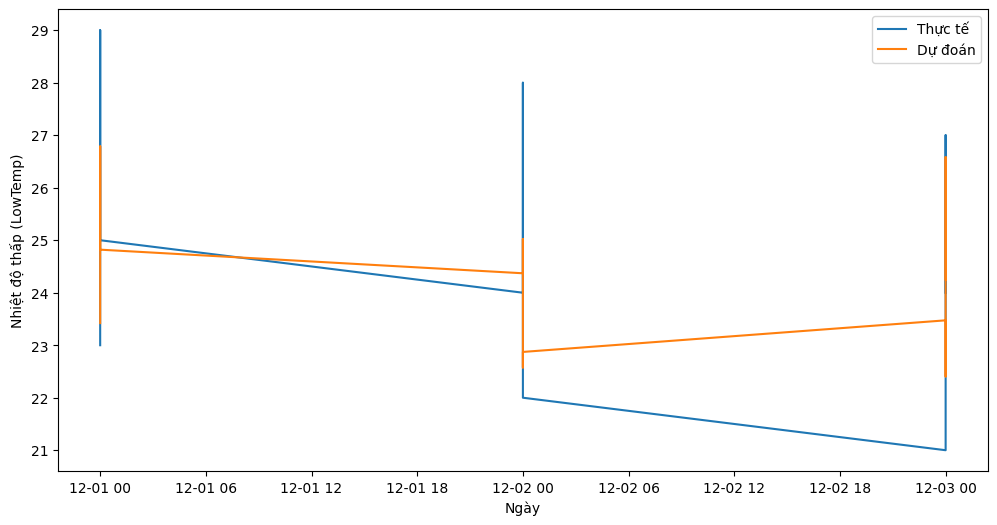

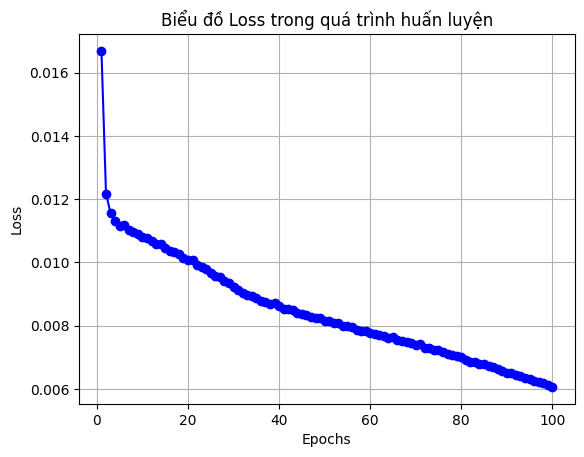

,Dự đoán,Thực tế
0,23.421669,23.0
1,24.023342,23.0
2,26.786654,29.0
3,24.820213,25.0
4,24.370428,24.0
5,25.022610,28.0
6,22.575272,22.0
7,22.872204,22.0
8,23.474049,21.0
9,22.404829,22.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Đọc dữ liệu vào DataFrame
data = pd.read_csv("/content/drive/MyDrive/DAMH/Data/PreparedData/prepared_data_weather.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Lọc dữ liệu
data = data[['LowTemp', 'HighTemp', 'Humidity', 'Barometer', 'WindDegrees', 'WindSpeed']]

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_data = data[data.index.month != data.index.month.max()]
test_data = data[data.index.month == data.index.month.max()]

# Tính toán giá trị tối thiểu và tối đa của cột 'LowTemp' gốc
min_low_temp = train_data['LowTemp'].min()
max_low_temp = train_data['LowTemp'].max()

# Chuẩn bị dữ liệu cho mô hình LSTM
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Tạo dữ liệu chuỗi thời gian
def create_time_series_data(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), :])
        y.append(data[i + look_back, 0])  # Dự đoán nhiệt độ thấp (LowTemp)
    return np.array(X), np.array(y)

look_back = 12  # Độ dài của cửa sổ thời gian
X_train, y_train = create_time_series_data(train_data_scaled, look_back)
X_test, y_test = create_time_series_data(test_data_scaled, look_back)

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, train_data.shape[1])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=100, batch_size=32)

# Dự đoán thời tiết cho 12 ngày tiếp theo
predicted_values = []
input_data = X_test[0, :, :]  # Sử dụng dữ liệu kiểm tra đầu tiên
for i in range(12):
    input_data_reshaped = input_data.reshape(1, look_back, train_data.shape[1])
    prediction = model.predict(input_data_reshaped)
    predicted_values.append(prediction[0, 0])
    input_data = np.roll(input_data, -1, axis=0)  # Đẩy dữ liệu cuối cùng ra để thêm dự đoán

# Chuyển ngược lại dự đoán
predicted_values = np.array(predicted_values).reshape(-1, 1) * (max_low_temp - min_low_temp) + min_low_temp

# Chuyển dữ liệu dự đoán và thực tế thành các mảng 1 chiều
predicted_values = predicted_values.reshape(-1)
actual_values = test_data['LowTemp'][:12].values

# Tạo DataFrame chứa dự đoán và thực tế
prediction_df = pd.DataFrame({'Dự đoán': predicted_values, 'Thực tế': actual_values})
# Vẽ biểu đồ dự đoán và thực tế
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[:12], test_data['LowTemp'][:12], label='Thực tế')
plt.plot(test_data.index[:12], predicted_values, label='Dự đoán')
plt.xlabel('Ngày')
plt.ylabel('Nhiệt độ thấp (LowTemp)')
plt.legend()
plt.show()

# Lấy giá trị loss từ history
loss_values = history.history['loss']

# Vẽ biểu đồ loss
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-', color='b')
plt.title('Biểu đồ Loss trong quá trình huấn luyện')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

prediction_df

Epoch 1/100
534/534 [==============================] - 12s 18ms/step - loss: 0.0170
Epoch 2/100
534/534 [==============================] - 8s 15ms/step - loss: 0.0125
Epoch 3/100
534/534 [==============================] - 10s 19ms/step - loss: 0.0118
Epoch 4/100
534/534 [==============================] - 9s 17ms/step - loss: 0.0114
Epoch 5/100
534/534 [==============================] - 7s 13ms/step - loss: 0.0113
Epoch 6/100
534/534 [==============================] - 5s 10ms/step - loss: 0.0111
Epoch 7/100
534/534 [==============================] - 4s 8ms/step - loss: 0.0111
Epoch 8/100
534/534 [==============================] - 6s 10ms/step - loss: 0.0110
Epoch 9/100
534/534 [==============================] - 6s 11ms/step - loss: 0.0109
Epoch 10/100
534/534 [==============================] - 4s 8ms/step - loss: 0.0107
Epoch 11/100
534/534 [==============================] - 4s 8ms/step - loss: 0.0106
Epoch 12/100
534/534 [==============================] - 7s 13ms/step - loss: 0.0106
Ep

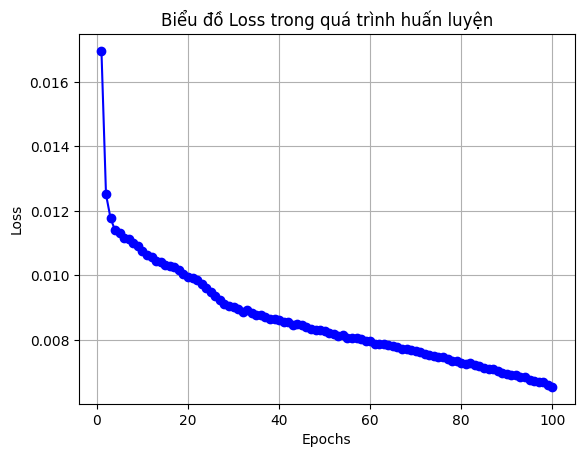

In [ ]:

# Đọc dữ liệu vào DataFrame
data = pd.read_csv("/content/drive/MyDrive/DAMH/Data/PreparedData/prepared_data_weather.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Lọc dữ liệu
features = ['LowTemp', 'HighTemp', 'Humidity', 'Barometer', 'WindDegrees', 'WindSpeed']
data = data[features]

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_data = data[data.index.month != data.index.month.max()]
test_data = data[data.index.month == data.index.month.max()]

# Chuẩn bị dữ liệu cho mô hình LSTM
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

look_back = 12  # Độ dài của cửa sổ thời gian
X_train, y_train = create_time_series_data(train_data_scaled, look_back)
X_test, y_test = create_time_series_data(test_data_scaled, look_back)

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, len(features))))  # Cần có một lớp đầu vào cho mỗi đặc trưng
model.add(Dense(len(features)))  # Cần có một lớp đầu ra cho mỗi đặc trưng
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=100, batch_size=32)

# Dự đoán tất cả các đặc trưng cho 12 buổi tiếp theo
predicted_values = []
input_data = X_test[0, :, :]  # Sử dụng dữ liệu kiểm tra đầu tiên
for i in range(12):
    input_data_reshaped = input_data.reshape(1, look_back, len(features))
    prediction = model.predict(input_data_reshaped)
    predicted_values.append(prediction[0])
    input_data = np.roll(input_data, -1, axis=0)  # Đẩy dữ liệu cuối cùng ra để thêm dự đoán

# Chuyển ngược lại dự đoán
predicted_values = np.array(predicted_values)
predicted_values = scaler.inverse_transform(predicted_values)

# Tạo DataFrame cho dự đoán và thực tế cho từng đặc trưng
prediction_dfs = {}
for i, feature in enumerate(features):
    predicted_feature = predicted_values[:, i]
    actual_feature = test_data[feature][:12].values
    prediction_df = pd.DataFrame({'Dự đoán': predicted_feature, 'Thực tế': actual_feature})
    prediction_dfs[feature] = prediction_df

# Lấy giá trị loss từ history
loss_values = history.history['loss']

# Vẽ biểu đồ loss
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-', color='b')
plt.title('Biểu đồ Loss trong quá trình huấn luyện')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [ ]:
# Chuyển prediction_dfs thành một DataFrame
df_combined = pd.DataFrame()

for feature, prediction_df in prediction_dfs.items():
    # Đặt tên cột dự đoán và thực tế dựa trên tên đặc trưng
    prediction_col_name = f'{feature}_Dự đoán'
    actual_col_name = f'{feature}_Thực tế'

    # Đổi tên cột trong prediction_df
    prediction_df = prediction_df.rename(columns={'Dự đoán': prediction_col_name, 'Thực tế': actual_col_name})

    # Nối dự đoán và thực tế vào DataFrame chung
    if df_combined.empty:
        df_combined = prediction_df
    else:
        df_combined = pd.concat([df_combined, prediction_df], axis=1)

In [ ]:
df_combined

,LowTemp_Dự đoán,LowTemp_Thực tế,HighTemp_Dự đoán,HighTemp_Thực tế,Humidity_Dự đoán,Humidity_Thực tế,Barometer_Dự đoán,Barometer_Thực tế,WindDegrees_Dự đoán,WindDegrees_Thực tế,WindSpeed_Dự đoán,WindSpeed_Thực tế
0,22.245750,23.0,26.139248,25.0,50.987118,98.0,896.144409,1008.0,105.498222,0.0,3.371485,0.833334
1,21.753830,23.0,25.682487,31.0,48.564835,84.0,890.503723,1010.0,95.329338,0.0,3.033728,1.388890
2,27.506851,29.0,31.513641,33.0,72.640030,57.0,950.476929,1007.0,209.920975,0.0,6.712057,2.222224
3,25.423920,25.0,29.375200,29.0,64.059349,83.0,929.019592,1008.0,168.295563,0.0,5.385212,1.111112
4,24.797737,24.0,28.763943,28.0,61.591633,73.0,922.367188,1008.0,155.760529,337.5,4.994904,2.777780
5,23.198641,28.0,27.127670,32.0,54.950550,45.0,905.729309,929.0,124.579773,315.0,3.970679,3.333336
6,21.999102,22.0,25.893082,25.0,50.108494,98.0,893.494324,1008.0,101.182655,0.0,3.218335,1.944446
7,21.707790,22.0,25.636061,32.0,48.503876,66.0,890.872986,1009.0,95.621994,0.0,3.044709,3.888892
8,22.660074,21.0,26.625879,24.0,52.245186,82.0,900.555298,923.0,114.822212,0.0,3.635552,1.666668
9,21.376078,22.0,25.382318,29.0,47.239994,74.0,886.899292,931.0,88.719536,0.0,2.821675,1.111112


In [ ]:
# Tạo DataFrame mới chỉ chứa các cột dự đoán với tên gốc
df_predictions = df_combined.copy()

# Đặt lại tên cột dự đoán về tên gốc của dữ liệu
for feature in features:
    prediction_col_name = f'{feature}_Dự đoán'
    df_predictions[feature] = df_predictions[prediction_col_name]
    df_predictions = df_predictions.drop(columns=prediction_col_name)
    df_predictions = df_predictions.drop(columns=f'{feature}_Thực tế')
df_predictions.to_csv('/content/drive/MyDrive/DAMH/Data/PreparedData/df_predictions.csv')
df_predictions

,LowTemp,HighTemp,Humidity,Barometer,WindDegrees,WindSpeed
0,22.245750,26.139248,50.987118,896.144409,105.498222,3.371485
1,21.753830,25.682487,48.564835,890.503723,95.329338,3.033728
2,27.506851,31.513641,72.640030,950.476929,209.920975,6.712057
3,25.423920,29.375200,64.059349,929.019592,168.295563,5.385212
4,24.797737,28.763943,61.591633,922.367188,155.760529,4.994904
5,23.198641,27.127670,54.950550,905.729309,124.579773,3.970679
6,21.999102,25.893082,50.108494,893.494324,101.182655,3.218335
7,21.707790,25.636061,48.503876,890.872986,95.621994,3.044709
8,22.660074,26.625879,52.245186,900.555298,114.822212,3.635552
9,21.376078,25.382318,47.239994,886.899292,88.719536,2.821675
